In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, StateStore, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2

## Dirs

In [106]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"
logging_dir = "/n/holystore01/LABS/iaifi_lab/Users/smsharma/set-diffuser/logging/"
run_name = "iconic-eon-17"  # wandb run name

## Load data

In [107]:
n_particles = 5000
n_features = 7

# Load and normalize
x = np.load("{}/halos.npy".format(data_dir))
x_mean = x.mean(axis=(0,1))
x_std = x.std(axis=(0,1))
x = (x - x_mean + 1e-7) / (x_std + 1e-7)

x = x[:, :n_particles, :n_features]
conditioning = np.array(pd.read_csv("{}/cosmology.csv".format(data_dir)).values)
mask = np.ones((x.shape[0], n_particles))

## Load cluster run

In [108]:
config_file = "../logging/cosmology/{}/config.yaml".format(run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [109]:
print("{} devices visible".format(jax.device_count()))

# Load the dataset
train_ds = load_data(config.data.dataset, config.data.n_features, config.data.n_particles, config.training.batch_size, config.seed, **config.data.kwargs)
batches = create_input_iter(train_ds)

# VDM and Transformer score model configuration
transformer_dict = FrozenDict({"d_model": config.transformer.d_model, "d_mlp": config.transformer.d_mlp, "n_layers": config.transformer.n_transformer_layers, "n_heads": config.transformer.n_heads, "induced_attention": config.transformer.induced_attention, "n_inducing_points": config.transformer.n_inducing_points})
vdm = VariationalDiffusionModel(n_layers=config.vdm.n_encoder_layers, d_embedding=config.vdm.d_embedding, d_hidden_encoding=config.vdm.d_hidden_encoding, timesteps=config.vdm.timesteps, d_feature=config.data.n_features, transformer_dict=transformer_dict, embed_context=config.vdm.embed_context, n_classes=config.vdm.n_classes)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

1 devices visible
Params: 8,698,821


In [110]:
ckpt_dir = "{}/cosmology/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

## Generate and evaluate simulations

In [123]:
n_samples = 16
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=cond_gen, mask=mask_gen)
x_samples = x_samples.mean()

Text(0.5, 0, 'z')

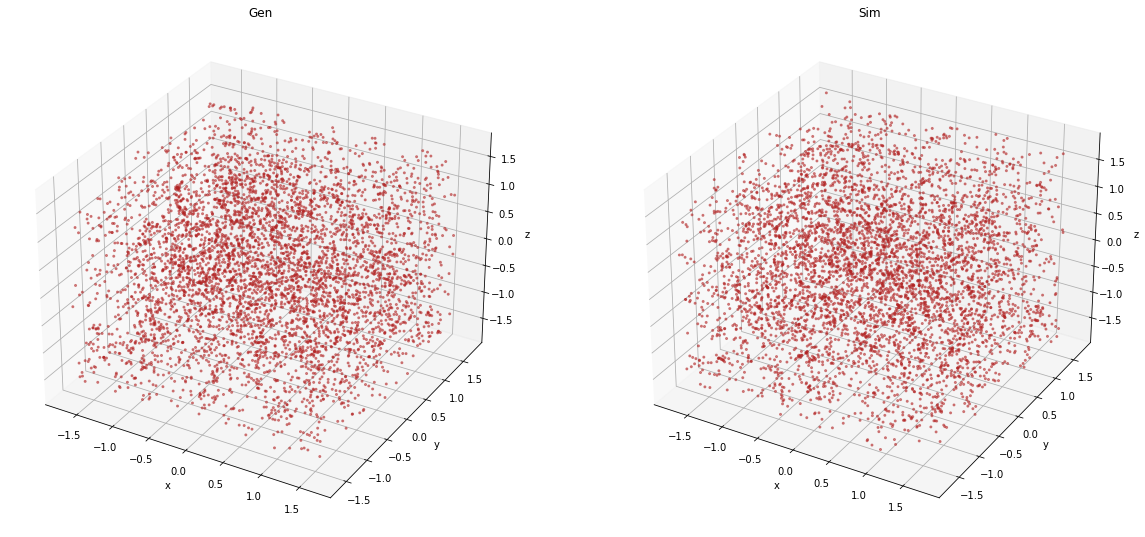

In [124]:
idx = 0

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

In [125]:
x_rnd = jax.random.uniform(rng, shape=x[idx_rnd[idx], :config.data.n_particles, :3].shape, minval=0, maxval=1000)

Text(0, 0.5, 'y')

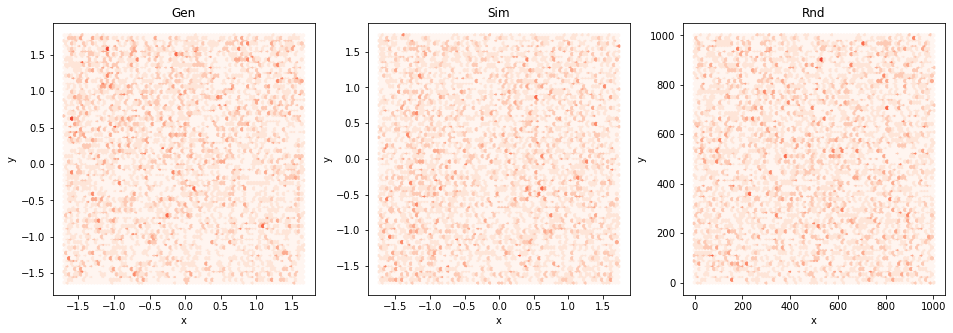

In [126]:
s = 4
alpha = 0.5
color = "firebrick"
gs = 80
cmap = "Reds"

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

vmin=0
vmax=10

ax1.hexbin(x_samples[idx, :, 0], x_samples[idx, :, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.hexbin(x[idx, :config.data.n_particles, 0], x[idx_rnd[idx], :config.data.n_particles, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

ax3.hexbin(x_rnd[:config.data.n_particles, 0], x_rnd[:config.data.n_particles, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title("Rnd")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

In [127]:
sys.path.append("../../ili-summarizer/")
sys.path.append("../../ili-summarizer/summarizer/")

from knn.knn import KNN
from data.catalogue import Catalogue

In [128]:
r_bins = np.linspace(0, 100, 100)
k = np.arange(1, 10)
knn = KNN(r_bins, k)

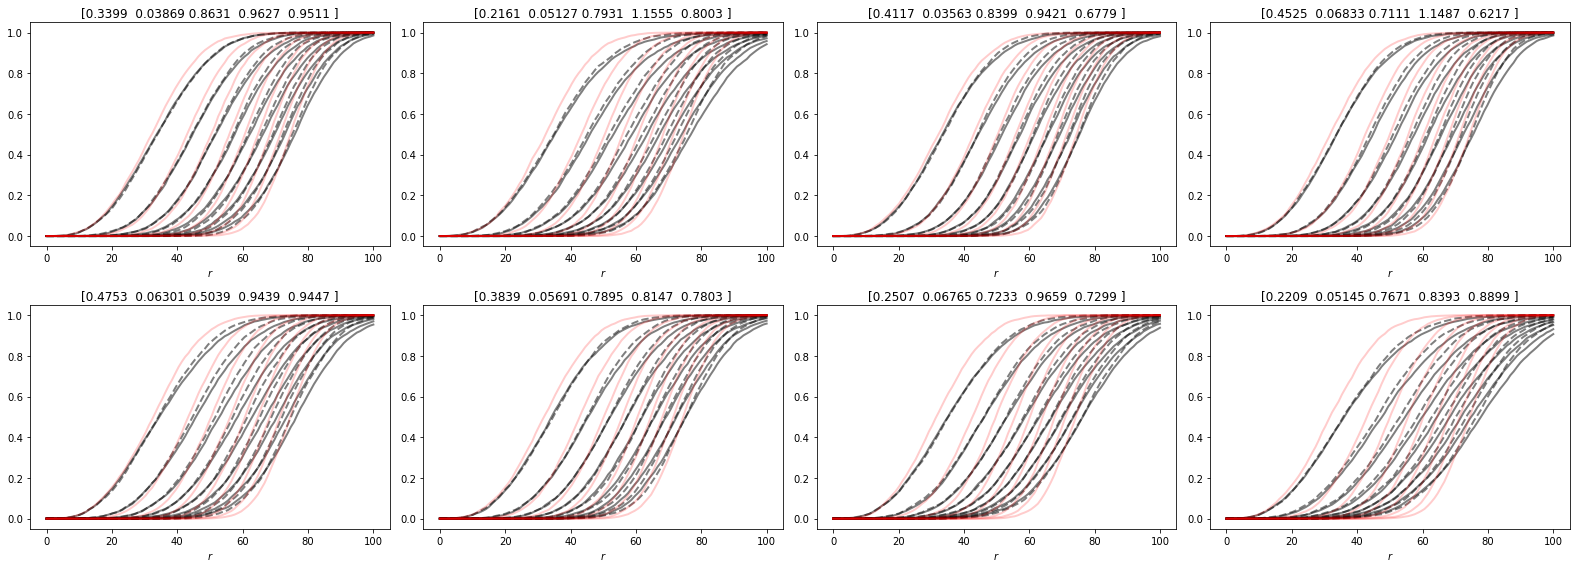

In [129]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(22, 8))
gs = GridSpec(2, 4)

for idx in range(8):
    
    ax = fig.add_subplot(gs[idx])
    
    cat = Catalogue(pos=x[idx_rnd[idx], :config.data.n_particles, :3] * x_std[:3] + x_mean[:3], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color='k', ls='--', alpha=0.5, lw=2, label="Sim" if i == 0 else None)

    cat = Catalogue(pos=x_samples[idx, :, :3] * x_std[:3] + x_mean[:3], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color='k', ls='-', alpha=0.5, lw=2, label="Gen" if i == 0 else None)

    cat = Catalogue(pos=x_rnd, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color='red', ls='-', alpha=0.2, lw=2, label="Rnd" if i == 0 else None)

    ax.set_xlabel("$r$")

    ax.set_title(conditioning[idx_rnd[idx]])

plt.tight_layout()

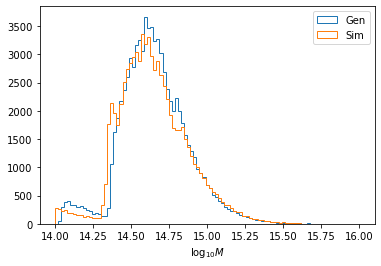

In [130]:
# Masses

bins = np.linspace(14, 16, 100)
plt.hist(vnp.array(np.log10(x_samples[:, :, -1].flatten() * x_std[-1] + x_mean[-1])), bins=bins, histtype='step', label="Gen");
plt.hist(vnp.array(np.log10(x[idx_rnd, :, -1].flatten() * x_std[-1] + x_mean[-1])), bins=bins, histtype='step', label="Sim");
plt.xlabel(r"$\log_{10}M$")
plt.legend()

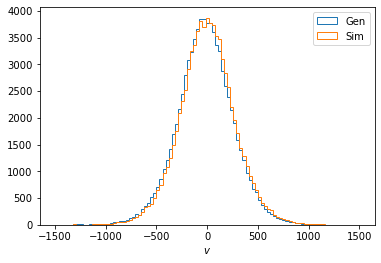

In [131]:
# Velocities

idx = 5  # Choose a velocity component

bins = np.linspace(-1500, 1500, 100)
plt.hist(vnp.array((x_samples[:, :, idx].flatten() * x_std[idx] + x_mean[idx])), histtype='step', label="Gen", bins=bins);
plt.hist(vnp.array((x[idx_rnd, :, idx].flatten() * x_std[idx] + x_mean[idx])), histtype='step', label="Sim", bins=bins);
plt.xlabel(r"$v$")
plt.legend()

## Save samples

In [ ]:
np.savez("/n/holystore01/LABS/iaifi_lab/Users/smsharma/set-diffuser/data/nbody_samples.npz",
         x_true=x[idx_rnd],
         x_samples=x_samples,
         cosmology=conditioning[idx_rnd])

## Generate samples from same cosmology

In [120]:
omega_m = 0.2  # Set parameters
sigma_8 = 0.7

cosmology = np.mean(conditioning, axis=0)

cosmology = cosmology.at[0].set(omega_m)
cosmology = cosmology.at[-1].set(sigma_8)

In [121]:
n_samples = 10  # How many samples from same cosmology

rng = jax.random.PRNGKey(33)
x_samples_cosmo = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=np.repeat(np.array([cosmology]), n_samples, 0), mask=np.ones((n_samples, config.data.n_particles)))
x_samples_cosmo = x_samples_cosmo.mean()

Text(0.5, 0, 'z')

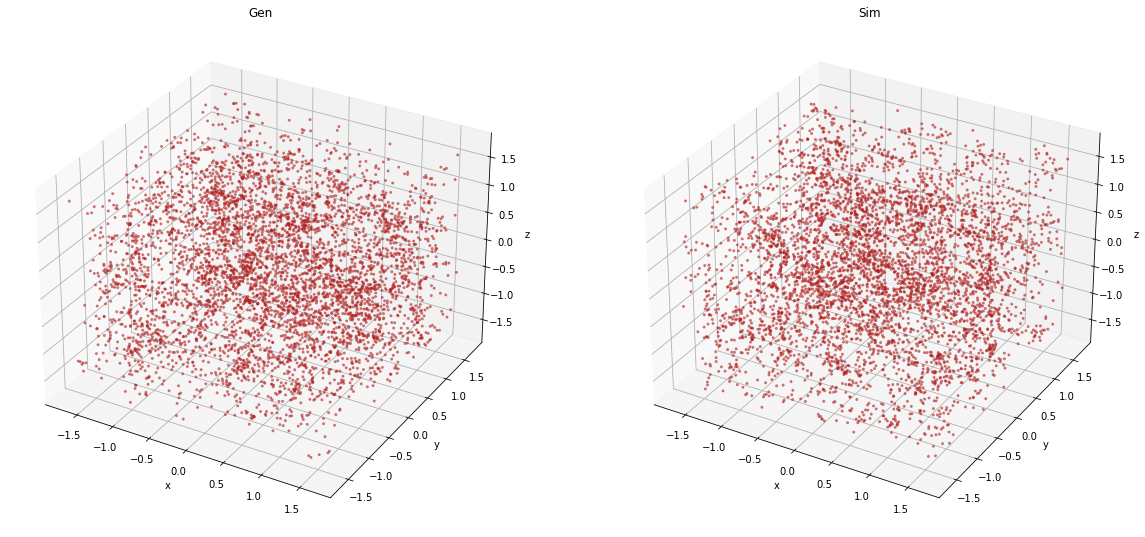

In [122]:
s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

idx = 0
ax1.scatter(x_samples_cosmo[idx, :, 0], x_samples_cosmo[idx, :, 1], x_samples_cosmo[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

idx = 1
ax2.scatter(x_samples_cosmo[idx, :, 0], x_samples_cosmo[idx, :, 1], x_samples_cosmo[idx, :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")